In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torchvision import transforms, models
import torchvision

from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

from tqdm import tqdm

In [2]:
DICT_CLASSES = {
    155: 0,
    159: 1,
    162: 2,
    167: 3,
    182: 4,
    193: 5,
    207: 6,
    229: 7,
    258: 8,
    273: 9,
}

DICT_BREEDS = {
    0: 'Shih-Tzu',
    1: 'Rhodesian ridgeback',
    2: 'Beagle',
    3: 'English foxhound',
    4: 'Border terrier',
    5: 'Australian terrier',
    6: 'Golden retriever',
    7: 'Old English sheepdog',
    8: 'Samoyed',
    9: 'Dingo',
    -1: 'Not a dog'
}

In [3]:
class Model(torch.nn.Module):
    def __init__(self, breed_nums=None):
        super(Model, self).__init__()
        self.resnet = models.resnet152(pretrained=True)             
        self.breed_nums = breed_nums
    def forward(self, x):
        x = self.resnet(x)
        if self.breed_nums is not None:
            x = x[:, self.breed_nums]
        return x
    
def decode_predictions(labels):
    return list(map(DICT_BREEDS.get, labels))

In [4]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [5]:
dataset = torchvision.datasets.ImageFolder('data/val', transform=transform)
dataloader  = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# EDA

Первая мысль, которая приходит на ум, что если данные являются подможеством imagenet, то стоит взять предобученную сеть на imagenet и прогнать наши валидацонные данные через нее

При этом нужно как-то обработать классы, предсказываемые моделью, которые выходят за рамки 10ти классов пород собак. Будем превращать такие предсказания в -1

In [6]:
model = Model()
model.to('cuda')
model.eval();

In [7]:
breed_nums = sorted(list(DICT_CLASSES.keys()))
breed_nums_set = set(breed_nums)

unique_labels = list(map(DICT_BREEDS.get, sorted(DICT_BREEDS.keys())))

In [8]:
y_true = []
y_pred = []
for tensor, labels in tqdm(dataloader):
    tensor = tensor.to('cuda')

    with torch.set_grad_enabled(False):
        preds = model(tensor)
    pred_labels = preds.argmax(dim=1).data.cpu().tolist()
    y_true += labels.tolist()
    y_pred += list(map(lambda x: DICT_CLASSES.get(x) if x in breed_nums_set else -1, pred_labels))

100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [03:15<00:00,  2.52it/s]


In [9]:
y_true_decoded = np.array(decode_predictions(y_true))
y_pred_decoded = np.array(decode_predictions(y_pred))

In [10]:
print(classification_report(y_true_decoded, y_pred_decoded, digits=3))

                      precision    recall  f1-score   support

  Australian terrier      0.993     0.663     0.795       407
              Beagle      0.949     0.852     0.898       418
      Border terrier      0.997     0.890     0.941       401
               Dingo      0.994     0.815     0.895       410
    English foxhound      0.966     0.643     0.772       224
    Golden retriever      0.991     0.840     0.910       401
           Not a dog      0.000     0.000     0.000         0
Old English sheepdog      0.998     0.955     0.976       422
 Rhodesian ridgeback      0.994     0.814     0.895       408
             Samoyed      1.000     0.932     0.965       429
            Shih-Tzu      1.000     0.817     0.899       409

            accuracy                          0.832      3929
           macro avg      0.898     0.747     0.813      3929
        weighted avg      0.989     0.832     0.901      3929



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
data = confusion_matrix(y_true_decoded, y_pred_decoded, labels=unique_labels)
pd.DataFrame(data=data, columns=unique_labels, index=unique_labels)

,Not a dog,Shih-Tzu,Rhodesian ridgeback,Beagle,English foxhound,Border terrier,Australian terrier,Golden retriever,Old English sheepdog,Samoyed,Dingo
Not a dog,0,0,0,0,0,0,0,0,0,0,0
Shih-Tzu,74,334,0,0,0,0,0,1,0,0,0
Rhodesian ridgeback,72,0,332,1,0,0,1,2,0,0,0
Beagle,58,0,0,356,4,0,0,0,0,0,0
English foxhound,59,0,2,18,144,0,0,0,0,0,1
Border terrier,43,0,0,0,0,357,0,0,0,0,1
Australian terrier,135,0,0,0,0,1,270,0,1,0,0
Golden retriever,64,0,0,0,0,0,0,337,0,0,0
Old English sheepdog,19,0,0,0,0,0,0,0,403,0,0
Samoyed,29,0,0,0,0,0,0,0,0,400,0


Как мы можем заметить наша модель очень любит находить классы, которые не следовало бы

Значит попробуем ограничить разнообразие ее предсказаний лишь нашими десятью классами, Как это сделать? - будем находить argmax не от всего массива а лишь от тех значений, в которых находятся рассматриваемые нами классы

In [18]:
model = Model(breed_nums=breed_nums)
model.to('cuda')
model.eval();

In [19]:
y_true = []
y_pred = []
for tensor, labels in tqdm(dataloader):
    tensor = tensor.to('cuda')

    with torch.set_grad_enabled(False):
        preds = model(tensor)

    y_true += labels.tolist()
    y_pred += preds.argmax(dim=1).data.cpu().tolist()

100%|████████████████████████████████████████████████████████████████████████████████| 492/492 [03:17<00:00,  2.49it/s]


In [20]:
y_true_decoded = np.array(decode_predictions(y_true))
y_pred_decoded = np.array(decode_predictions(y_pred))

In [21]:
print(classification_report(y_true_decoded, y_pred_decoded, digits=3))

                      precision    recall  f1-score   support

  Australian terrier      0.988     0.971     0.979       407
              Beagle      0.923     0.950     0.936       418
      Border terrier      0.985     0.973     0.979       401
               Dingo      0.973     0.963     0.968       410
    English foxhound      0.914     0.853     0.882       224
    Golden retriever      0.978     0.983     0.980       401
Old English sheepdog      0.988     1.000     0.994       422
 Rhodesian ridgeback      0.962     0.983     0.972       408
             Samoyed      0.998     0.998     0.998       429
            Shih-Tzu      0.981     0.988     0.984       409

            accuracy                          0.971      3929
           macro avg      0.969     0.966     0.967      3929
        weighted avg      0.971     0.971     0.971      3929



In [22]:
data = confusion_matrix(y_true_decoded, y_pred_decoded, labels=unique_labels)
pd.DataFrame(data=data, columns=unique_labels, index=unique_labels)

,Not a dog,Shih-Tzu,Rhodesian ridgeback,Beagle,English foxhound,Border terrier,Australian terrier,Golden retriever,Old English sheepdog,Samoyed,Dingo
Not a dog,0,0,0,0,0,0,0,0,0,0,0
Shih-Tzu,0,404,1,0,0,0,1,1,2,0,0
Rhodesian ridgeback,0,0,401,1,0,0,1,4,0,0,1
Beagle,0,1,2,397,14,1,0,1,0,0,2
English foxhound,0,0,4,26,191,1,0,0,0,0,2
Border terrier,0,4,1,1,1,390,2,0,0,0,2
Australian terrier,0,1,2,0,0,4,395,1,3,0,1
Golden retriever,0,2,2,0,0,0,0,394,0,0,3
Old English sheepdog,0,0,0,0,0,0,0,0,422,0,0
Samoyed,0,0,1,0,0,0,0,0,0,428,0


# Анализ ошибок

Самый заметный недостаток нашей модели заключается в том, что она путается в породах Бигля и Английского фоксхаунда, причем принимает Фоксхауда за Бигля в 2 раза чаще, чем Бигля за Фоксхаунда. Давайте постараемся ответить на 2 вопроса:
* Почему путается?
* Почему в 2 раза чаще?

In [327]:
beagle_indexes = np.where(y_true_decoded == 'Beagle')[0]
foxhaund_indexes = np.where(y_true_decoded == 'English foxhound')[0]

dataset_without_transform = torchvision.datasets.ImageFolder('data/val')

In [365]:
def show_subsample_of_imgs(dataset, indexes1, indexes2, title1, title2, sample_len=3):
    subsample1 = np.random.choice(indexes1, size=sample_len, replace=False)
    subsample2 = np.random.choice(indexes2, size=sample_len, replace=False)
    fig, axes = plt.subplots(nrows=sample_len, ncols=2, figsize=(20, 20))
    for i, (index1, index2) in enumerate(zip(subsample1, subsample2)):
        axes[i, 0].imshow(np.asarray(dataset[index1][0]))
        axes[i, 1].imshow(np.asarray(dataset[index2][0]))
        if i == 0:
            axes[0, 0].set_title(title1)
            axes[0, 1].set_title(title2)

### 1. Собаки этих пород сами по себе похожи (Почему путается?)

Давайте посмотрим на случайные фотографии собак этих пород, чтобы убедиться в этом 

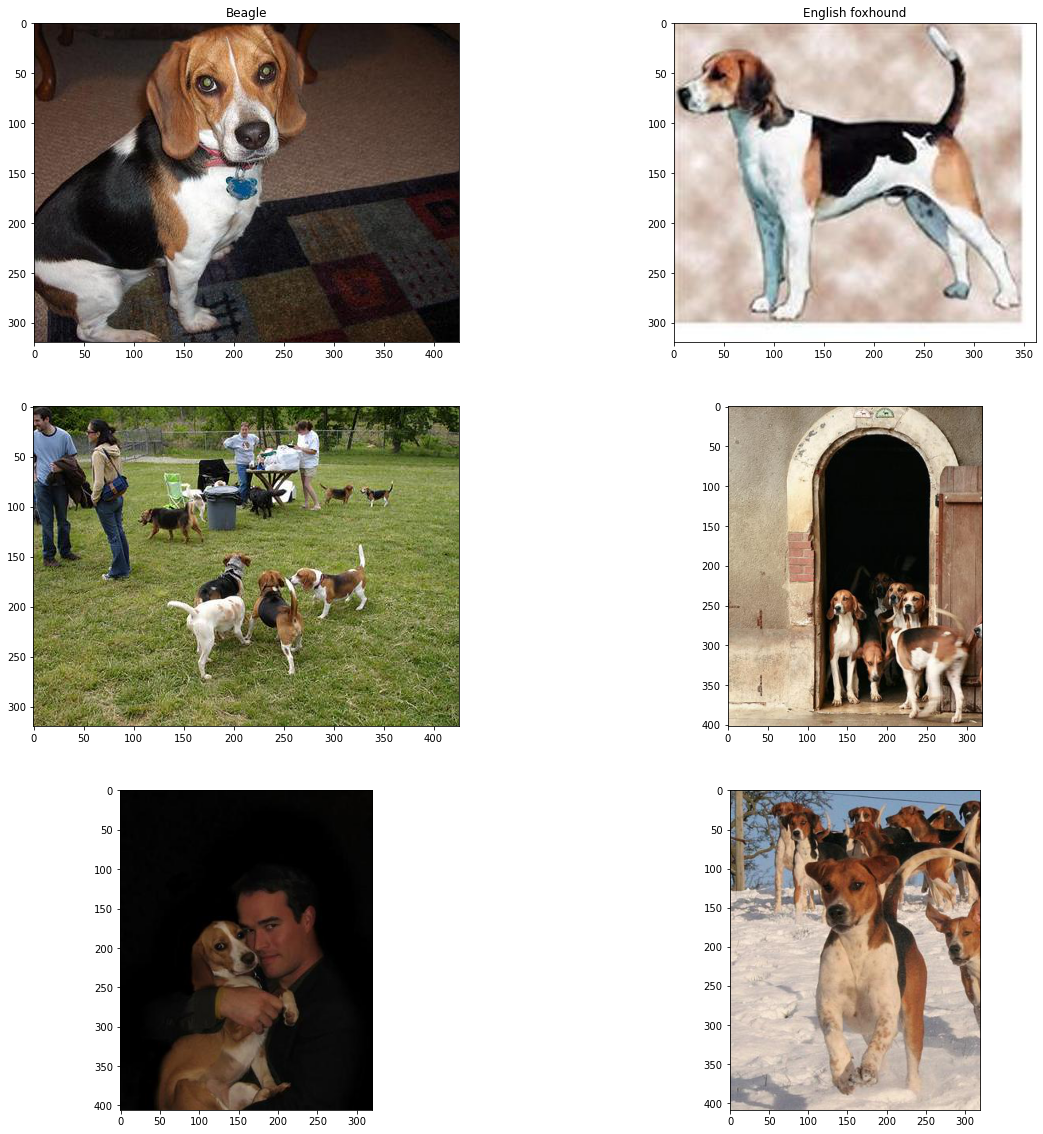

In [366]:
show_subsample_of_imgs(
    dataset_without_transform, 
    beagle_indexes, 
    foxhaund_indexes, 
    title1='Beagle', title2='English foxhound'
)

Вывод: действительно, очень похожи!

### 2. Некачественная разметка (Почему путается?)

Эта проблема вытекает скорее всего из первой, так как не самый удачный представитель одной породы может легко спутаться с другой.

Я подобрал проблемные изображения, в которых модель в соотсветствии с разметкой ошибается, но при этом разметка не соответсвует реальной породе собаки

In [367]:
false_beagle = [1252, 1305, 1308, 1309, 1330, 1369, 1377, 1396, 1242, 1334, 1408, 1441, 1457]
# subsample отсюда -> np.where((y_pred == 'Beagle') & (y_true == 'English foxhound'))[0]

false_foxhound = [953, 1086, 1183]
# subsample отсюда -> np.where((y_pred == 'English foxhound') & (y_true == 'Beagle'))[0]

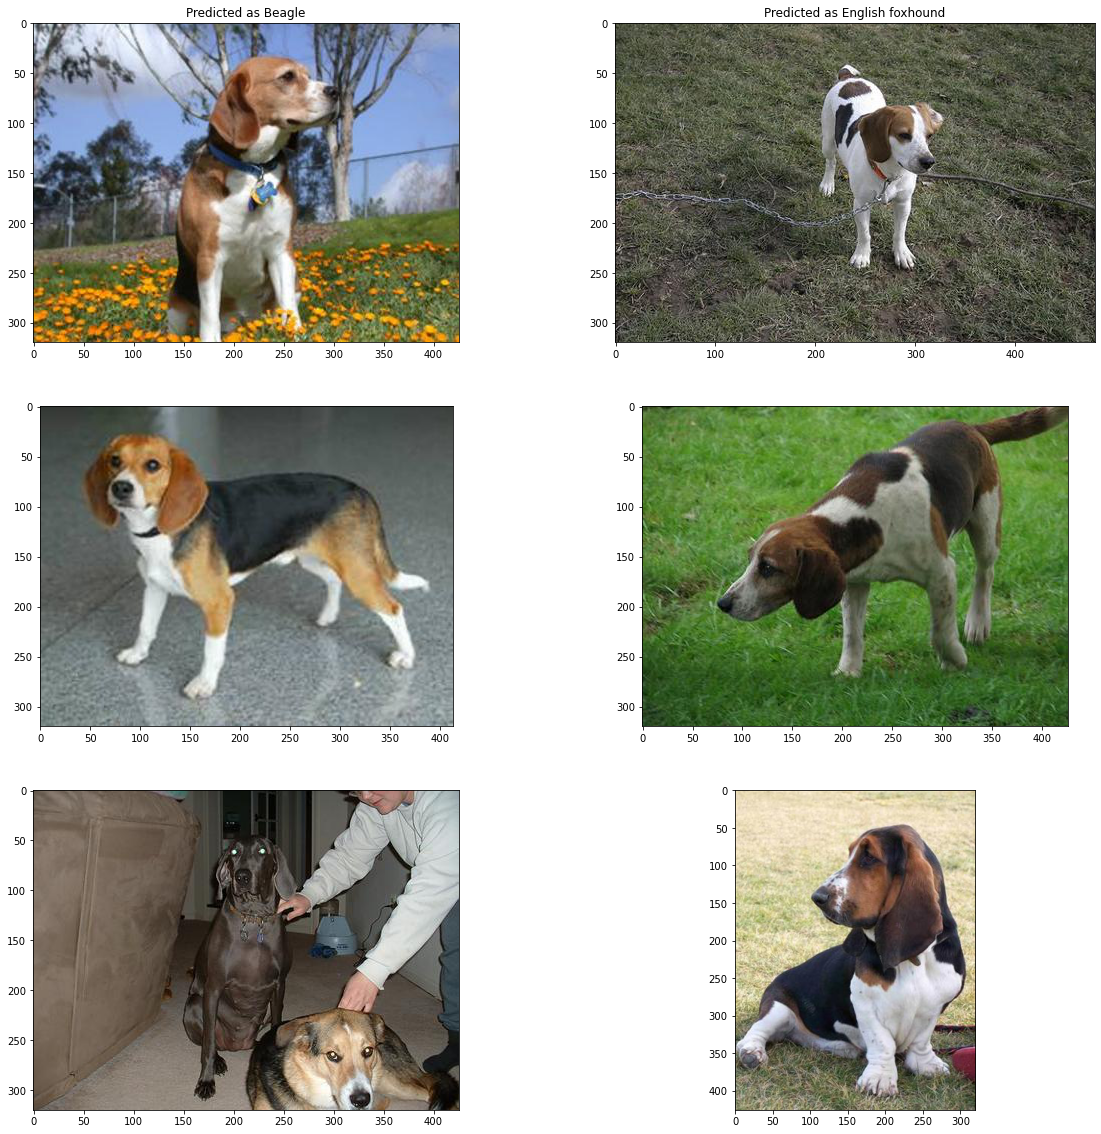

In [368]:
show_subsample_of_imgs(
    dataset_without_transform, 
    false_beagle, 
    false_foxhound, 
    title1='Predicted as Beagle', title2='Predicted as English foxhound'
)

При тщательном рассмотрении изображений собак можно понять, что первые 2 ряда изображений моделью предсказаны верно, хоть и разметка говорит обратное, а в 3ем ряду на изображениях вообще представлены другие породы собак. 

### 3. Несбалансированность классов (Почему в 2 раза чаще?)

Посмотрим на распределение классов

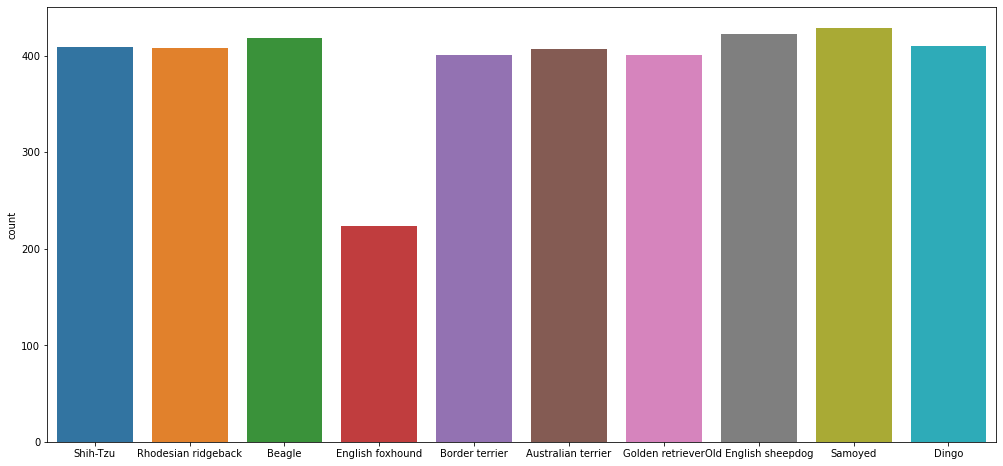

In [376]:
plt.figure(figsize=(17, 8))
sns.countplot(y_true_decoded)

Как мы видим в нашей выборке собак породы Бигли в 2 раза больше собак чем породы Английского фоксхаунда. Соответсвенно и ошибочных предсказаний для Бигля будет в 2 раза больше

## В целом можно сделать вывод о том, что вышеперечисленные проблемы в данных в действительности не могут быть описаны нашей моделью